In [1]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## **Task**

We want to train an MLP to learn the construction of names. To achieve this we want to maximise the likelihood of the $N$ names observed in the dataset:

$$
\max_{\theta} \sum_{i=1}^{N} \hat{p}(\mathbf{x}_i) = \max_{\theta} \sum_{i=1}^{N} \prod_{j=1}^{M_i} \hat{p}(x_j | x_{j-1}, x_{j-2}, x_{j-3}; \theta)
$$

In particular, we choose to break down the probability of a name into the product of the conditional probabilities of each character given a three-letter context window (we use '.' as the special token to pad the start and end of a name). For example, the name "John" would give us the following data points:

* ... $\rightarrow$ J
* ..J $\rightarrow$ o
* .Jo $\rightarrow$ h
* Joh $\rightarrow$ n
* ohn $\rightarrow$ .

We begin by constructing a training set of such data points from all the names in the dataset. We then use the negative log-likelihood of the data as the loss function to be minimized. See `mm_intro.ipynb` for more details.

# **Dataset**

In [2]:
# Load data
words = open('names.txt', 'r').read().splitlines()
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
# Create a dictionary that maps characters to integers and vice versa
char2idx = {c: i+1 for i, c in enumerate('abcdefghijklmnopqrstuvwxyz')}
char2idx['.'] = 0 # special character for marking start and end of a word
idx2char = {i: c for c, i in char2idx.items()}

In [5]:
# Form training pairs (context, target characters)
block_size = 3 # context size for next character prediction

def build_dataset(words):
    X, Y = [], []
    for word in words:
        w2idx = [0] * block_size + [char2idx[c] for c in word] + [0]
        for i in range(len(w2idx) - block_size):
            X.append(w2idx[i:i+block_size])
            Y.append(w2idx[i+block_size])

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape, X.dtype, Y.dtype)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

X_train, Y_train = build_dataset(words[:n1]) # 80% of words
X_val, Y_val = build_dataset(words[n1:n2]) # 10% of words
X_test, Y_test = build_dataset(words[n2:]) # 10% of words

# print first 10 samples of X_train and Y_train
# for i in range(len(Y_train[:10])):
#     print(''.join([idx2char[idx.item()] for idx in X_train[i]]), '->', idx2char[Y_train[i].item()])

torch.Size([182580, 3]) torch.Size([182580]) torch.int64 torch.int64
torch.Size([22767, 3]) torch.Size([22767]) torch.int64 torch.int64
torch.Size([22799, 3]) torch.Size([22799]) torch.int64 torch.int64


# **MLP**

We will use a simple MLP with an embedding layer for the input (shared across all characters), one hidden layer, and a softmax output layer. The approach is similar to the one used in the paper [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).

1. **Embedding Layer**: As done in `mm_intro.ipynb`, characters are represented as one-hot vectors and passed through an embedding layer to obtain a dense representation. Regarding the implementation, we observe that a matrix multiplication of one-hot vectors with an embedding matrix is equivalent to a lookup in the embedding matrix. This can be implemented using simple indexing operations in PyTorch which is a lot more efficient than matrix multiplication: `emb = C[X]`.
2. **Hidden Layer**: The hidden layer is a fully connected layer with weights and biases. The input to the hidden layer is the concatenation of the embeddings of the three characters in the context window. To perform this concatenation, we use the `view` function in PyTorch which is extremely efficient as it doesn't directly manipulate the data in memory but simply changes its interpretation. 
3. **Output Layer**: The output layer is a fully connected layer with weights and biases. The output of the hidden layer is passed through this layer to obtain the logits for each character in the vocabulary. 
4. **Loss**: Instead of manually implementing the softmax and cross-entropy loss to compute the negative log-likelihood from the logits as we did in `mm_intro.ipynb`, we use PyTorch's `torch.nn.functional.cross_entropy` function which combines the two operations into one and is numerically not only more stable but also more efficient in the forward and backward passes. This is because the softmax and cross-entropy operations are fused into a single kernel and computed together. For more info, refer to the [YoutTube video](https://youtu.be/TCH_1BHY58I?t=1968) associated with this tutorial.

Note that when implementing models in PyTorch, it's always important to double-check the shapes of the tensors at each step using a small batch of data to make sure that the operations are being performed as intended.

In [132]:
# Hyperparameters
emb_dim = 10 # embedding dimension
h1_dim = 200 # hidden layer dimension

# For reproducibility
g = torch.Generator().manual_seed(2147483647)

# Embedding layer
C = torch.randn((27, emb_dim), generator=g) # shape: (vocab_size, emb_dim)
# Hidden layer
W1 = torch.randn((block_size * emb_dim, h1_dim), generator=g)  * ((5/3) / (block_size * emb_dim)**0.5) # kaiming init, shape: (block_size * emb_dim, h1_dim)
b1 = torch.randn((h1_dim), generator=g) * 0.01 # shape: (h1_dim)
# Output layer
W2 = torch.randn((h1_dim, 27), generator=g) * 0.01 # shape: (h1_dim, vocab_size)
b2 = torch.zeros((27)) # shape: (vocab_size)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
print('Number of parameters:', sum([p.numel() for p in parameters]))

Number of parameters: 11897


# **Training**

Once you have built your model it's good practice to check that it's working as expected by overfitting it on a small batch of data. This means that the model should be able to memorize the data and achieve a loss of 0. 

In our case, we overfit the model to the first five entries of our `words` dataset by rerunning the training set construction code above with `words[:5]`. We then train the model for 1000 epochs and observe that the loss does indeed decrease significantly (to $0.2535$). The reason, however, why we are not able to achieve a loss of $0$, despite having a relatively large model of $3481$ parameters for only five words (32 samples), is because in some cases there is more than one possible next character given the context window. For example, in the 32 samples, the context window "..." appears multiple times and is followed by different characters. Hence, there is some inherent ambiguity in the data which prevents the model from achieving a loss of $0$.

To compare the model's predictions with our labels `Y`, we can use the `torch.argmax` function along the first dimension of the `logits` to obtain the index of the character with the highest probability and compare the two.

In [133]:
# Stat tracking
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre # log scale LRs over range [1e-3, 1]
lr_i = []
loss_i = []

In [134]:
batch_size = 32
max_steps = 50000
learning_rate = 0.01

# Training loop
for i in range(max_steps):
    # mini-batch sampling
    batch_idxs = torch.randperm(len(Y_train))[:batch_size]
    X_batch, Y_batch = X_train[batch_idxs], Y_train[batch_idxs]
  
    # forward pass
    emb = C[X_batch] # shape: (#samples, block_size, emb_dim) 
    emb_cat = emb.view(-1, block_size * emb_dim) # shape: (#samples, block_size * emb_dim)
    h_preact = emb_cat @ W1 + b1 # shape: (#samples, hidden_dim)
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2 # shape: (#samples, vocab_size)
    loss = F.cross_entropy(logits, Y_batch) # shape: (1)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    lr = learning_rate # during LR tuning, use lrs[i] instead
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    # lr_i.append(lre[i])
    loss_i.append(loss.log10().item())

# Plot loss vs. learning rate
# plt.plot(lr_i, loss_i)

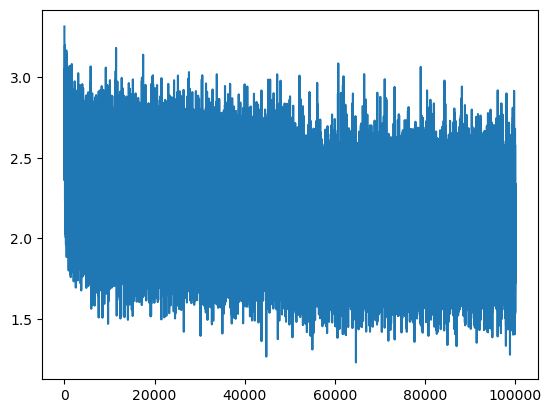

In [119]:
# A thick band of the loss curve indicates that our batch size may be too small, i.e. the gradients are too noisy.
plt.plot([10 ** v for v in loss_i]);

## Learning Rate

When training a model, it's important to pick the right learning rate. If the learning rate is too small, the model will take a long time to converge. If the learning rate is too large, the model will diverge and the loss will increase. One simple approach to find the optimal learning rate is to test a range of learning rates and pick the one that achieves the lowest loss. In particular, we may choose to test $1000$ learning rates logarithmically over the range $[1\mathrm{e}{-3}, 1]$. For each learning rate we run a single batch of training and record the loss. We then plot the loss against the learning rate and pick the learning rate that achieves the lowest loss, `plt.plot(lr_i, loss_i)`. After training our model for a sufficient number of epochs at this optimal learning rate, we can additionally perform a _learning rate decay_ (e.g. $\times 0.1$) to potentially achieve an even lower loss.

## Weight Initialization

Another important aspect of training a model is to initialize the weights of the model properly. This can have a significant impact on the convergence of the model. It is often the case that for any given task we're solving, we know approximately what the scale of the loss should be to begin with. For example, in our case, we know that the loss should be around $-\log(1/27) \approx 3.2958$ (assuming a uniform distribution over the vocabulary to start). Hence, we can initialize the weights of the model such that the loss is around this value. In particular, let's try to initialize the weights of the output layer using a normal distribution with mean $0$ and standard deviation $\sigma = 0.01$ and set the biases to $0$. This is because for the outputs (logits), we don't want to be adding any unnecessary non-uniform bias which would shift the distribution away from the uniform distribution. 

```python
W2 = torch.randn((h1_dim, 27), generator=g) * 0.01 
b2 = torch.zeros((27))
```

When we improve the initialization of these weights, we observe that the initial loss in the first training iteration is indeed a lot lower than before and around the expected value of $3.2958$. As a consequence of this improved weight inititialization, we observe that the loss curve doesn't resemble a hockey stick anymore and the model is able to spend more time in the region of low loss, improving the convergence of the model.

## Activation Function Saturation

When using non-linearities such as the sigmoid or tanh activation functions, it's important to be aware of the saturation problem and to understand in which range our activations lie. If a large number of activations lie in the saturated region of the non-linearity, then the gradients will be very small or even zero and the model will not be able to learn effectively. To analyse this we can plot the distribution of the activations (and pre-activations) of the hidden layer.

```python
plt.hist(h_preact.view(-1).tolist(), 50);
plt.hist(h.view(-1).tolist(), 50);
```

We observe that the tanh activations of the hidden layer are indeed largely saturated, i.e. close to $-1$ or $1$. This is because the pre-activations of the hidden layer are large (in the range of $[-20, 20]$) and hence these large values are squashed into the saturated region of the tanh non-linearity. The severity of this issue is understood when we recognize that the local gradient of the tanh function is $1 - t^2$ where $t$ is the value of the tanh function. Hence, when an activation $t$ is close to $1$ or $-1$, the local gradient is close to $0$ and the back-propagating gradients will not be able to flow through these activation nodes. The zero-gradient issue also makes sense intuitively, if we consider that slightly chaning a value (preactivation) that lies in the saturated region will not move it out of this region and hence not affect the loss function in any way, i.e. the gradient is zero. Note also the fact gradients flowing through a tanh node can only ever decrease (scaled by $1 - t^2$ which lies in the range of $[0, 1]$).

In addition to plotting histograms, we can also plot an "activation map" to see across multiple samples, which activations are above a certain threshold. 

```python
plt.figure(figsize=(12, 4))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');
```

One major problem would be if this map show an entire column of only white pixels. This would indicate a dead neuron which is always outputting $1$ or $-1$ regardless of the input and hence not learning anything. A dead neuron may be caused by inappropriate weight initialization or also during training if sudden large gradient knocks the neuron off the data manifold and into a saturated region from which it can't recover. We could interpret this as a permanent "brain damage" of the network w.r.t. this neuron.

### Solution

In our case we visualised the plots after the first training iteration and observe the overly saturated activations. Thus, to resolve this issue we want to try to reduce the size of the pre-activations. This can be achieved by adapting the weight initialization of the hidden layer, similar to what we did for the output layer. We simply want to scale the Gaussian distribution by a small factor such that the pre-actiavtions are smaller and hence only a small number of activations are saturated. This will also speed up the convergence of the model as the neurons receive more non-zero gradients to learn from.

Now, instead of manually guessing the factor by which we want to scale the Gaussian-initialized weights which would become increasingly more tedious the deeper our networks, we can use a more principled approach. In particular, the idea is to scale the variance of the Gaussian by an amount that encourages the pre-activations and hence also the activations to take on reasonable values without being too small or too large (effectively remaining in the range of unit Gaussian). To achieve this we look to the paper [Kaiming He et al. 2015](https://arxiv.org/pdf/1502.01852.pdf) which proposes the following initialization scheme for the weights of a fully connected layer: 

$$
W \sim \mathcal{N}(0, \sqrt{\frac{g}{n_{in}}})
$$

where $n_{in}$ is the number of inputs to the layer and $g$ is the gain factor. The gain factor is chosen such that the variance of the pre-activations is $1$ (unit Gaussian) and depends on the non-linearity used, refer to the [PyTorch documentation](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain) for more details. In our case, we use the tanh non-linearity and hence set $g = 5/3$:

```python
W1 = torch.randn((block_size * emb_dim, h1_dim), generator=g) * ((5/3) / (block_size * emb_dim)**0.5) # kaiming init
```

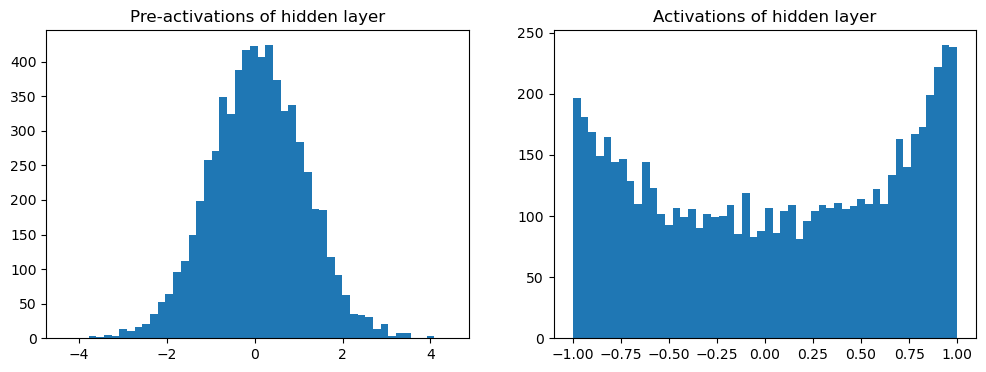

In [112]:
# Plotting the pre-activations and activations of the hidden layer
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(h_preact.view(-1).tolist(), 50);
ax2.hist(h.view(-1).tolist(), 50);
ax1.set_title('Pre-activations of hidden layer');
ax2.set_title('Activations of hidden layer');

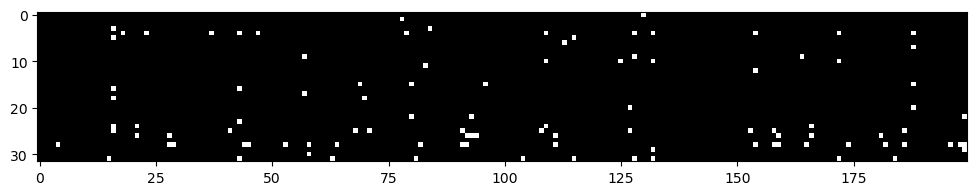

In [113]:
# Activations above the saturation threshold
plt.figure(figsize=(12, 4))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

## Validation

Once we have trained our model, we want to evaluate its performance on a validation set. In particular, we want to check that the model is not overfitting to the training set and that it is able to generalize to unseen data. To do this, we compute the loss on the validation set and compare it to the loss on the training set. If the loss on the validation set is significantly higher than the loss on the training set, then the model is overfitting. In this case, we may want to consider using a smaller model or adding regularization techniques such as dropout. However, if the loss on the validation set is similar to the loss on the training set, then the model is underfitting and can expect to achieve better performance by using a larger model.

The trick when adapting the model to these findings is to do it systematically. We may begin increasing the size of one layer and be aware of bottlenecks that may arise due to the size of the other layers not being large enough. We may also want to consider adding more layers to the model. In general, it's good practice to start with a small model and gradually increase its size until we start to see diminishing returns. In our case we started with an embedding size of $2$ per character and a hidden layer of size $100$. We then increased the embedding size to $10$ and the hidden layer size to $200$ to achieve a validation loss of $2.1983$ and a training loss of $2.1703$, when training for $50\text{k}$ steps with $\text{LR}{=}0.1$ and another $50\text{k}$ steps with $\text{LR}{=}0.01$. Batch size was $32$. At this point our model may be big enough where it's starting to overfit to the training set. 

In [120]:
# forward pass for validation / testing
def split_losss(split):
    X, Y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split] 
    with torch.no_grad():
        emb = C[X] # shape: (#samples, block_size, emb_dim) 
        h = torch.tanh(emb.view(-1, block_size * emb_dim) @ W1 + b1) # shape: (#samples, hidden_dim) 
        logits = h @ W2 + b2 # shape: (#samples, vocab_size)
        loss = F.cross_entropy(logits, Y) # shape: (1)
        print('Loss:', loss.item())

split_losss('train')
split_losss('val')

Loss: 2.060717821121216
Loss: 2.1120831966400146


## Embeddings

We can plot the embeddings of the characters in our vocabulary to see if there are any interesting patterns. For example, we may observe that vowels are clustered together. Furthermore, some of the more rare letters such as 'q' form outliers. As characters that are clustered together have similar embeddings, they may be interchangeable in some contexts. For example, the names "John" and "Jahn" are both valid names and the model should be able to predict the next character correctly in both cases.

In [ ]:
# Currently only works for 2D embeddings
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), idx2char[i], ha="center", va="center", color="white")
plt.grid('minor')

## Inference

Once we have trained our model, we can use it to generate new names. To do this, we first feed the model a context window of three characters and sample the next character from the distribution over the vocabulary. We then shift the context window by one character and repeat the process. We continue this process until we sample the special token '.' which indicates the end of a name.

In [131]:
for _ in range(10):
    name = ''
    context = [0] * block_size
    while True:
        # forward pass
        emb = C[context] 
        h = torch.tanh(emb.view(1, -1) @ W1 + b1) 
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample next character
        i = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [i]
        name += idx2char[i]
        if i == 0: 
            break
    print(name)

piyah.
azelma.
erik.
simerneliz.
natal.
dem.
kenderee.
canab.
evin.
sieleigh.
